## Digit Recognizer SVM

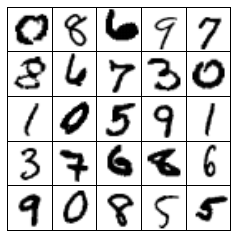

PCA - variance retained: 0%
Best parameters: {'estimator__kernel': 'poly', 'estimator__C': 10, 'estimator__degree': 2, 'estimator__gamma': 0.001}
Best score: 0.863184713376


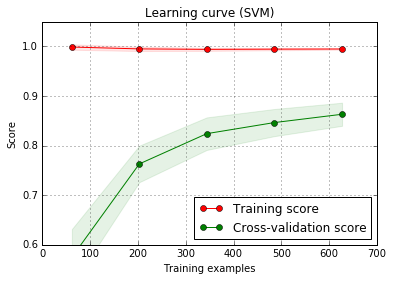

Complete!
2008.98399997


In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import cross_validation #import train_test_split
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.multiclass import OneVsRestClassifier
import csv
%matplotlib inline

TRAINING_FLAG = 0
SCALING = 1
PCA_FLAG = 1
timer_start = time.time()

#----------------------------------------------------------------------
def compose_image(data_slice):
    """
    Function takes a n x 28 data slice and outputs each row as
    a colourmap.
    """

    # Find number of images to display
    nrows = len(data_slice.index)
    nrows_root = math.ceil(math.sqrt(nrows))
    
    # For each image, reshape the data and add to a subplot
    fig = plt.figure(figsize=(4,4))
    for i in xrange(0,nrows):
        pixel_array = data_slice.iloc[i]
        pixel_array = pixel_array.reshape((28,28)).astype(np.uint8)
        ax = fig.add_subplot(nrows_root,nrows_root,i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='both', 
                        top='off',
                        bottom='off',
                        left='off',
                        right='off'
                      )
        ax.set_aspect('equal')
        ax.imshow(pixel_array, cmap=cm.binary)
    
    # Remove padding
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    return

#----------------------------------------------------------------------
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.
    """
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#----------------------------------------------------------------------
def export_to_csv(y_test):
    """
    Add headers and export the predictions to csv.
    """
    
    f = open('digit_recognizer_cv_pca.csv','w')
    result_str = 'ImageId,Label\n'
    total = 1
    for i in range(len(y_test)):
        label = str(y_test[i].astype('int'))
        result_str += str(total) + ',' + label + '\n'
        total += 1
    f.write(result_str)
    return

#----------------------------------------------------------------------
# Load datasets
data_all = pd.read_csv('../input/train.csv')
data_labels = data_all[[0]]
data_image = data_all.drop(data_all.columns[[0]], axis=1)
if TRAINING_FLAG != 1:
    x_test = pd.read_csv('../input/test.csv')

# Select a random permutation of images to display
row_selection = np.random.choice(data_image.index, 25)
data_slice = data_image.iloc[row_selection]
compose_image(data_slice)

# If training, split the data into train and test sets
if TRAINING_FLAG == 1:
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(
        data_image, data_labels, test_size = 0.3, random_state = 1)
else:
    x_train = data_image
    y_train = data_labels
    
# If scaling, scale X and Y
if SCALING == 1:
    xy_scaler = StandardScaler()
    xy_scaler.fit(x_train)
    x_train = xy_scaler.transform(x_train)

# If using PCA, find PCs to speed up learning - perhaps try MDA after?
if PCA_FLAG == 1:
    pca = PCA(0.95) # Return 95% of the variance 
    x_train = pca.fit(x_train).transform(x_train)
    print('PCA - variance retained: %i%%' % sum(pca.explained_variance_ratio_))
    
# Define SVM - basic, not optimised
clf_untuned = OneVsRestClassifier(SVC(kernel='rbf', random_state=0))

# Use cross validation / grid search to find optimal hyperparameters
cv = cross_validation.ShuffleSplit(data_image.shape[1], n_iter=50,
                                       test_size=0.2, random_state=0)

# If classifier is already tuned then run it, else do GridSearchCV
if 'clf_tuned' in locals() and hasattr(clf_tuned, 'best_params_'):
    #clf_tuned = OneVsRestClassifier(SVC(kernel='rbf',
    #                                    C=10, gamma=0.001, random_state=0, verbose=0, max_iter=1000))
    clf_tuned = OneVsRestClassifier(SVC(clf_tuned.best_estimator_,
                                                random_state=0, verbose=0))
    clf_tuned.fit(x_train, y_train)
else:
    params = {
        'estimator__C': [1, 10, 100],
        'estimator__gamma': [0.00001, 0.0001, 0.001],
        'estimator__kernel': ['poly', 'rbf'],
        'estimator__degree':[1, 2, 3],
    }
    clf_tuned = GridSearchCV(clf_untuned, cv=cv, param_grid=params)
    clf_tuned.fit(x_train, y_train)
    print('Best parameters: %s' % clf_tuned.best_params_)
    print('Best score: %s' % clf_tuned.best_score_)
    
# Plot learning curve for best params
title = 'Learning curve (SVM)'
plot_learning_curve(clf_tuned.best_estimator_, title, x_train, y_train, ylim=(0.6, 1.05), cv=cv)
plt.show()

# Evaluate on test set after transform if required
if SCALING == 1:
    x_test = xy_scaler.transform(x_test)
if PCA_FLAG == 1:
    x_test = pca.transform(x_test)
result = clf_tuned.predict(x_test)

# If training, evaluate performance, else export
if TRAINING_FLAG == 1:
    scoring = clf_tuned.score(x_test, y_test)
    print scoring
    actual = y_test['label']
    print '\n'
    print r'%i/%i (%i%%) correct!' % (sum(result == actual), result.shape[0], 
                                      (100*float(sum(result == actual)))//result.shape[0])
else:
    y_test = result
    export_to_csv(y_test)
    print 'Complete!'

timer_end = time.time()
print(timer_end - timer_start)

AttributeError: 'OneVsRestClassifier' object has no attribute 'params_'

In [36]:
    # Scale X and Y, remove bad values
    #xy_scaler = preprocessing.StandardScaler()
    #xy_scaler.fit(data[['X','Y']])
    #data[['X','Y']] = xy_scaler.transform(data[['X','Y']])
    #data = data[abs(data['Y']) < 100]
    #data.index = range(len(data))

    X = train_data[['X','Y']].as_matrix()
    ## Convert categories to numbers
    y = pd.get_dummies(train_data[['Category']])
    y = y.values.argmax(1)

    print X[0:5]
    print y[0:5]


## Gradient descent parameters
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
 
# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
     
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    # This is what we return at the end
    model = {}
     
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
 
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        # Backpropagation
        delta3 = probs
        #print delta3[0:5]
        #print range(num_examples)
        #print y[0:5]
        #print y.size
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
         
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(model))
     
    return model


def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .05, X[:, 0].max() + .05
    y_min, y_max = X[:, 1].min() - .05, X[:, 1].max() + .05
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.title("Decision Boundary for hidden layer size 3")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()
    

# Load my data or example data
my_setup()

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)
 
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x), X, y)

Original data size: 301050
Training set size: 3327
Test set size: 1673
[[-0.14868049 -0.09110246]
 [-0.78187016  0.06374198]
 [ 0.69188377 -0.10546471]
 [ 0.86422044  0.02161251]
 [ 0.09745502 -0.01488257]]
[1 0 1 0 1]
Loss after iteration 0: 3.702169
Loss after iteration 1000: 19.539387
Loss after iteration 2000: 87.492432
Loss after iteration 3000: 109.502198
Loss after iteration 4000: 29.947186
Loss after iteration 5000: 117.838669
Loss after iteration 6000: 80.127617
Loss after iteration 7000: 55.560188
Loss after iteration 8000: 114.646156
Loss after iteration 9000: 98.457121
Loss after iteration 10000: 134.311423
Loss after iteration 11000: 26.668053
Loss after iteration 12000: 30.907124
Loss after iteration 13000: 37.348430
Loss after iteration 14000: 25.245174
Loss after iteration 15000: 59.949669
Loss after iteration 16000: 54.057261
Loss after iteration 17000: 21.978027
Loss after iteration 18000: 100.773088
Loss after iteration 19000: 128.589311
